## <u>Project Objective</u>:

**Predict Federal Interest Decisions Based on Federal Reserve Speeches.**

* **Key Objectives:**
    * Predict Interest Decisions from Comprehensive Speech Content
    * Real-Time Prediction of Interest Decisions as Speech Progresses
    * Real-time Identification of Critical Interest Prediction Highlights

**For more details, see the README File.**

### Import Packages

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import shap
#Prediction Highlights
from utils.explain import HighlightsExtractor, specific_anchors_explainer
#Model Supporting utils
from utils.model_utils import (EvidenceExtractor, 
                               sentence_breaker,
                               sentence_breaker3, 
                               show_metrics, 
                               cumulate_sentences)
#preprocess utils
from utils.preprocess_utils import (split_name_role, 
                                    map_roles, 
                                    cat_interest_change, 
                                    cat_num_interest_change, 
                                    preprocess_speeches, 
                                    preprocess_interests, 
                                    tag_speeches)
#Visualiztions
from utils.visualizations import (styled_count_plot, 
                                  styled_hist, 
                                  read_speech, 
                                  common_words_count, 
                                  plot_interests, 
                                  styled_bar_plot, 
                                  speech_interest_visualize, 
                                  plot_one_class, 
                                  plot_some_classes,
                                  generate_word_cloud,
                                  plot_kdes)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.<u>Load Data & Preprocess</u>

##### Final preprocess to run

In [5]:
# load fed speeches text and features data
df= pd.read_csv('datasets/fed_speeches_1996_2020.csv', encoding='utf-8')

# load interest changes data
fed_interest_data= pd.read_csv('datasets/FED interest rates.csv')

# preprocess speeches data
speech_data=preprocess_speeches(df) 

# preprocess interests data
interest_data= preprocess_interests(fed_interest_data)

# merge speeches on a 30 days before decision window
tagged_df = tag_speeches(speech_data, interest_data, window_days=30)

# join texts in each 30 days tima window to a one long string
tagged_df["Texts"] = tagged_df["Texts"].apply(lambda x: "\n".join(x))

tagged_df.shape

(143, 4)

##### 1.1 Speech data

In [ ]:
#load fed speeches text and features data
df= pd.read_csv('datasets/fed_speeches_1996_2020.csv', encoding='utf-8')

##### 1.1.2. row example

In [229]:
# Speeches Data
pd.set_option('max_colwidth', 20)
df.head(1)

,link,title,speaker,event,year,text,date,text_len,location
0,https://www.fede...,Supervision of b...,Vice Chair Alice...,At the The Brook...,1996.0,I discovered whe...,19961219.0,3671,D.C.


In [237]:
# row example
read_speech(df, speech_num=0)

##### 1.1.3. Handling missing data and outliers

In [242]:
#Missing Values
df.isna().sum()

link        0
title       0
speaker     2
event       0
year        0
text        0
date        1
text_len    0
location    0
dtype: int64

In [241]:
#seems like partial speech info. will not use too short texts.
read_speech(df.sort_values(by='text_len').head(10)['text'])

,speech_text
241,Strengthening Risk Management for Derivatives
240,Structural Change and Monetary Policy
212,The Challenges of Global Financial Institution Supervision
227,The Economic Outlook and the Challenges Facing Monetary Policy
196,The Politics of Monetary Policy: Balancing Independence and Accountability
200,The Economic Outlook and the Challenges Facing Monetary Policy
205,Why Risk Management Is Important for Global Financial Institutions
211,"The Roles of Banks, Supervisors, and the Market in Advancing Risk Management"
627,"In my remarks today I will share my thoughts on the U.S. economic outlook for this year, focusing particularly on the prospects for economic growth and inflation. I will then turn to some implications of the outlook for current monetary policy. As always, my comments are my responsibility alone and do not necessarily reflect the views of my colleagues at the Federal Reserve.1"
592,"I would like to thank the North Carolina Bankers Association for inviting me to participate today in the annual convention. I want to discuss four regulatory issues that I know are of great interest to bankers in the audience today: sound practices for managing credit risk, particularly in residential and commercial real estate; compliance with the Bank Secrecy Act; recently issued guidance on overdraft protection; and progress on implementing new minimum regulatory capital requirements under the Basel framework, while updating the current Basel I framework."


##### 1.1.4 preprocess function for speeches data

In [271]:
#preprocess the speeches data
def preprocess_speeches(df):
    
    #initially there were 5 different roles of speakers:
    roles_list= ['Chairman', 'Vice Chairman', 'Governor', 'Chair', 'Vice Chair']

    data= split_name_role(df, 'speaker', roles_list) #split name and role to 2 different columns.
    data= map_roles(data) #map chairman and chair to be same role. map vice chair and vice chairman to same role.

    #only one date value missing-screen it.
    data= data[~data['date'].isna()]

    #fixing column data types
    data['date']=pd.to_datetime(data['date'].astype('int').astype('str'))
    data['year']= data['year'].astype(int)

    #screen texts with abnormal amount of words.
    data=data[data['text_len']>20]

    #sort by date
    data=data.sort_values(by='date')

    #reset to new index
    data= data.reset_index(drop=True)
    return data

data=preprocess_speeches(df)

##### 1.2. Interest Decisions Data

In [247]:
#load interest changes data
fed_interest_data= pd.read_csv('datasets/FED interest rates.csv')

##### 1.2.1. Some rows example

In [249]:
fed_interest_data.head(5)

,Release Date,Actual,Previous
0,"Dec 13, 2023",NaN,NaN
1,"Nov 01, 2023",NaN,5.50%
2,"Sep 20, 2023",5.50%,5.50%
3,"Jul 26, 2023",5.50%,5.25%
4,"Jun 14, 2023",5.25%,5.25%


##### 1.2.2. Missing values?

In [251]:
fed_interest_data.isna().sum()

Release Date    0
Actual          2
Previous        1
dtype: int64

##### 1.2.3. interest decisions data preprocess function 

In [253]:
def preprocess_interests(df):
    #fixing precentage and date column types 
    interest= df.copy()
    interest['Previous']=interest['Previous'].str.replace('%','').astype(float) 
    interest['Actual']=interest['Actual'].str.replace('%','').astype(float)
    interest['interest_date'] = pd.to_datetime(interest['Release Date'], format='%b %d, %Y')

    #adding decision columns
    interest['interest_change']=interest['Actual']-interest['Previous'] #interest change delta
    interest['decision'] = interest['interest_change'].apply(cat_interest_change) #increase/decrease/no_change
    interest['decision_num'] = interest['interest_change'].apply(cat_num_interest_change) #0:decrease, 1:no_change, 2: increase

    #screening unrelevant data
    interest=interest[interest['interest_date'] > '1996-01-01']
    interest=interest[~interest['Actual'].isna()] #screening missing values
    interest= interest.drop(columns=(['Release Date', 'Previous']))

    return interest

fed_interest= preprocess_interests(fed_interest_data)

##### 1.3.Merging the 2 datasets to create a tagged df

In [280]:
# create a tagged df: 
# 'Texts' column contains all speeches that were made a month before each interest decision.
# no_texts=False removes decisions without speeches in previous month. 
# 143 of them had federal reserve speeches within the previous month.

tagged_df = tag_speeches(speech_data, interest_data, no_texts=False)

# join texts in each row to one long string
tagged_df["Texts"] = tagged_df["Texts"].apply(lambda x: "\n".join(x))

tagged_df.shape

(143, 4)

In [285]:
#Examples of the tagged df
pd.set_option('max_colwidth', 100)
tagged_df.head(3)

,Decision,Texts,Decision_Date,Texts_Count
0,no_change,[ The coronavirus has left a devastating human and economic toll in its wake as it has spread ar...,2020-06-10,4
1,no_change,[ Good morning. The challenge we face today is different in scope and character from those we ha...,2020-04-29,1
2,decrease,"[ Comments on Monetary Policy in the Next Recession?, a report by Stephen Cecchetti, Michael Fer...",2020-03-15,4


### 2. <u>Exploratory Data Analysis</u>

In [24]:
speech_data.head(1)

,link,title,speaker,event,year,text,date,text_len,location,speaker_role,speaker_name
0,https://www.federalreserve.gov/boarddocs/speec...,Bank supervision in a world economy,Chairman Alan Greenspan,At the International Conference of Banking Sup...,1996,Remarks by Chairman Alan Greenspan Bank superv...,1996-06-13,3164,Sweden,Chair,Alan Greenspan


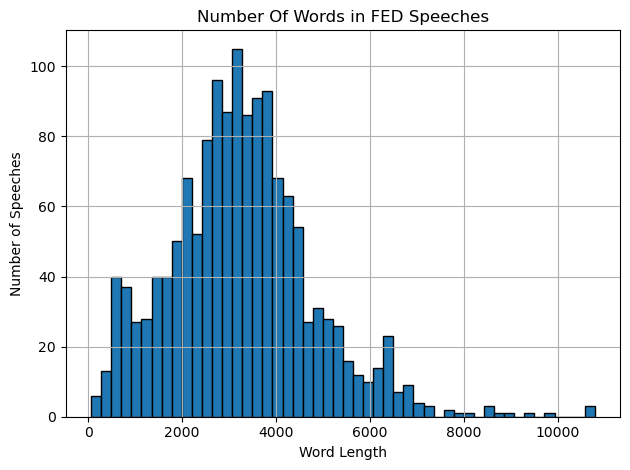

In [5]:
#Most commomn speech length is between 2K-4K Words.
styled_hist(speech_data['text_len'], 50)

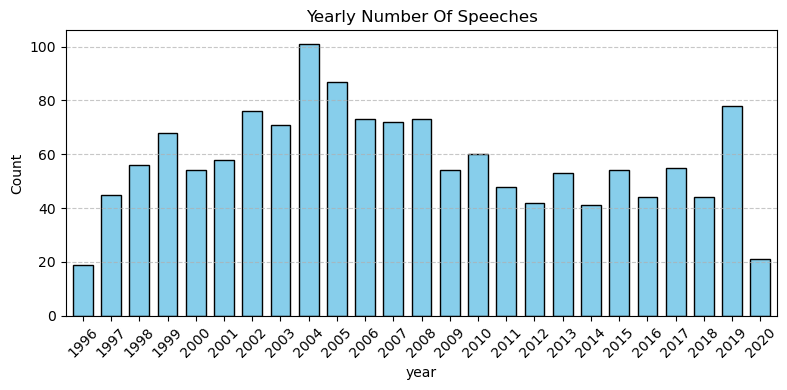

In [8]:
#number of yearly speeches ranges around 40-100.
#1996 and 2020 data seems to be partial.
#More yearly speeches between 2002-2008 and 2019.
styled_count_plot(speech_data, 'year', 'Yearly Number Of Speeches')

In [20]:
#looks like the speeches in the datset are between june 1996 to june 2020.
speech_data['date'].max() #2020-06-19
speech_data['date'].min() #1996-06-13

Timestamp('1996-06-13 00:00:00')

In [33]:
#event feature: 92% of events are unique.
pd.set_option('max_colwidth', 100)
speech_data['event'].nunique()/df.shape[0] 
speech_data['event'].head(5)

0                              At the International Conference of Banking Supervisors, Stockholm, Sweden
1                                                     At the CyberPayments '96 Conference, Dallas, Texas
2          At the National Association of Business Economists 38th Annual Meeting, Boston, Massachusetts
3    At the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washingto...
4                                       At the Small Business Development Conference, Richmond, Virginia
Name: event, dtype: object

In [34]:
#location Feature:
#166 unique locations
# Most speeches in D.C and New York
speech_data['location'].nunique() 
speech_data['location'].value_counts().head(15) 

D.C.              388
New York          198
Illinois           70
California         67
Massachusetts      56
Pennsylvania       46
Virginia           43
Missouri           37
Florida            32
Georgia            29
Germany            26
Ohio               26
North Carolina     26
Texas              24
Wyoming            22
Name: location, dtype: int64

In [5]:
#Some aggregated data by Speaker (Descending By number of speeches)
Speaker_Data = speech_data.groupby('speaker_name').agg(
    count=('year', 'count'),
    average_year=('year', 'mean'),
    most_common_role=('speaker_role', lambda x: x.mode()),
    average_len=('text_len', 'mean'),
    freq_speech_loc=('location', lambda x: x.mode())
    ).sort_values(by='count', ascending=False)

Speaker_Data.head(10)

,count,average_year,most_common_role,average_len,freq_speech_loc
speaker_name,,,,,
Ben S. Bernanke,214,2008.098131,Chair,3493.813084,D.C.
Alan Greenspan,183,2000.912568,Chair,2563.568306,D.C.
Roger W. Ferguson,96,2002.531250,Vice Chair,3141.406250,D.C.
Jerome H. Powell,82,2016.670732,Governor,2524.621951,D.C.
Susan S. Bies,77,2004.311688,Governor,3302.519481,"[D.C., New York]"
Donald L. Kohn,76,2006.671053,Vice Chair,3176.750000,D.C.
Lael Brainard,68,2017.382353,Governor,3423.911765,D.C.
Janet L. Yellen,66,2014.151515,Chair,3811.712121,D.C.
Laurence H. Meyer,65,1998.876923,Governor,4485.415385,D.C.


In [27]:
#most common title words are:
common_words_count(speech_data['title'], top_num=10)

financial    243
policy       219
monetary     201
economic     147
remarks      105
outlook       82
economy       80
community     76
banking       75
federal       71
dtype: int64

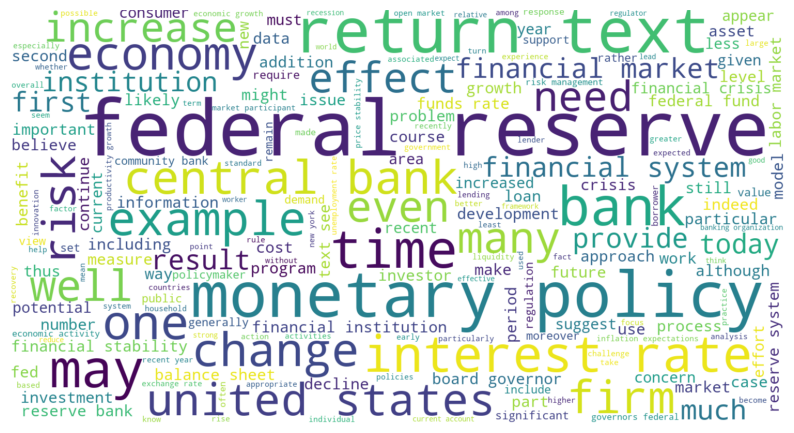

In [31]:
#most common speech words
unwanted_words = []
generate_word_cloud(tagged_df, 'Texts', unwanted_words, max_words=200)

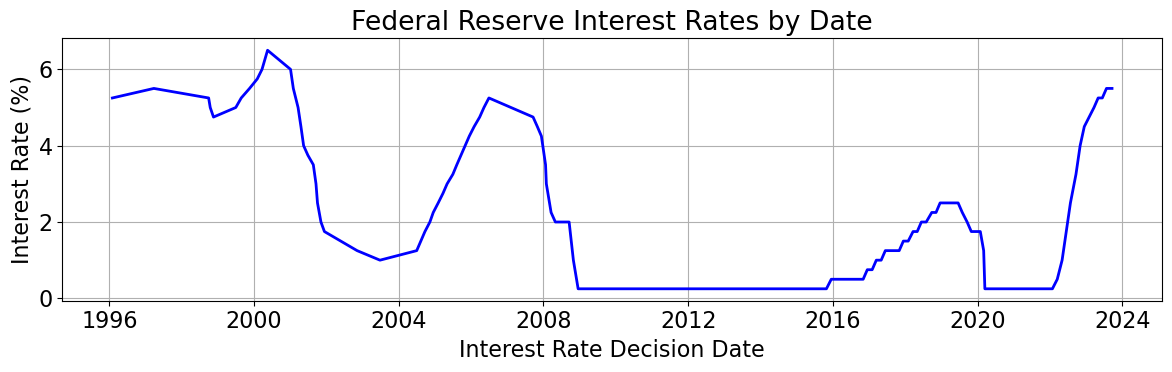

In [265]:
plot_interests(fed_interest['interest_date'], fed_interest['Actual'])

In [266]:
#count frequency of each interest decision.
fed_interest['interest_change'].value_counts()

 0.00    97
 0.25    37
-0.50    14
-0.25    14
 0.75     4
 0.50     3
-0.75     3
-1.00     1
Name: interest_change, dtype: int64

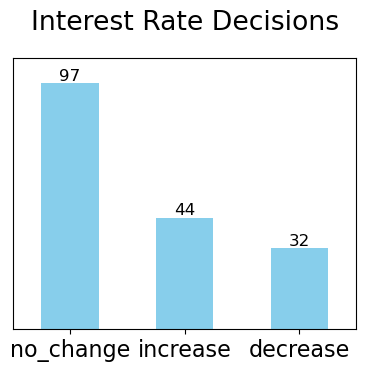

In [267]:
styled_bar_plot(fed_interest['decision'])

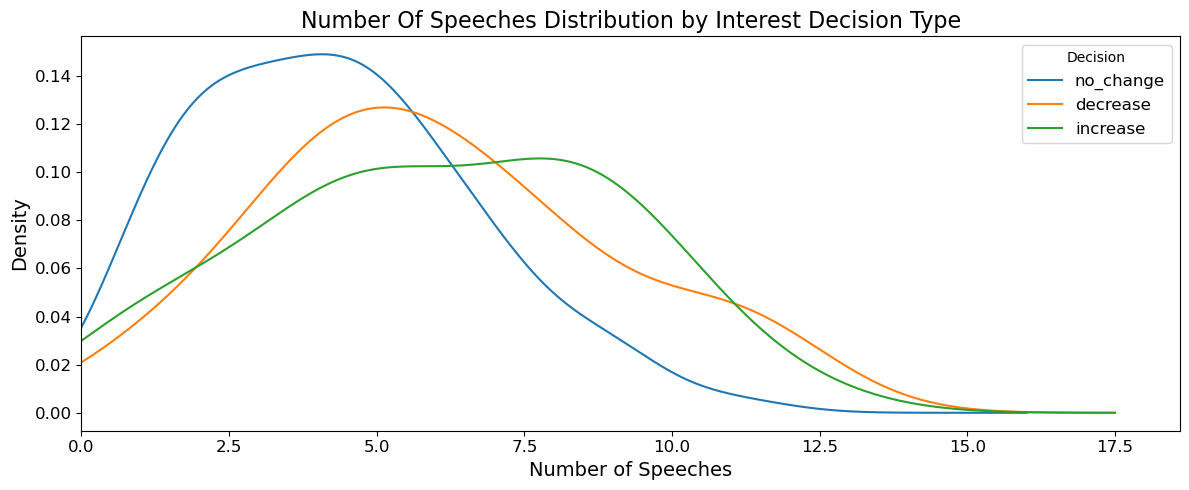

In [6]:
#Number of speeches in the month prior to the interest decision
plot_kdes(tagged_df, 'Texts_Count', 'Decision', xlabel='Number of Speeches', title= 'Number Of Speeches Distribution by Interest Decision Type')

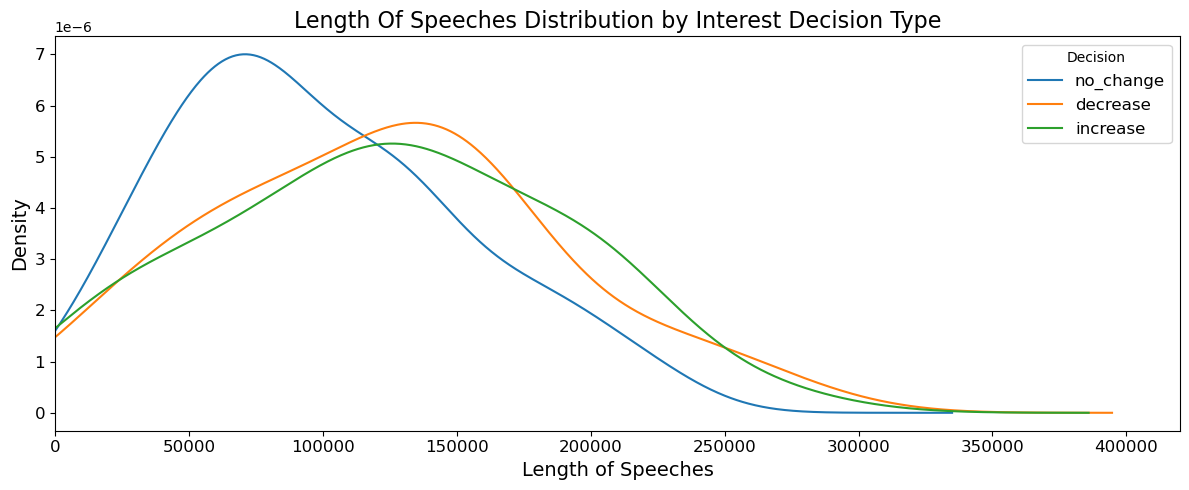

In [7]:
#Length of speeches in the month prior to the interest decision
tagged_df2= tagged_df
tagged_df2['text_len']= tagged_df['Texts'].str.len()
tagged_df2
plot_kdes(tagged_df2, 'text_len', 'Decision', xlabel='Length of Speeches', title= 'Length Of Speeches Distribution by Interest Decision Type')

In [268]:
#Decision num: 0=decrease, 1=no change, 2=increase.
interest_19= fed_interest[['interest_date', 'decision_num']][fed_interest['interest_date'].dt.year==2019]
interest_19

,interest_date,decision_num
33,2019-12-11,1
34,2019-10-30,0
35,2019-09-18,0
36,2019-07-31,0
37,2019-06-19,1
38,2019-05-01,1
39,2019-03-20,1
40,2019-01-30,1


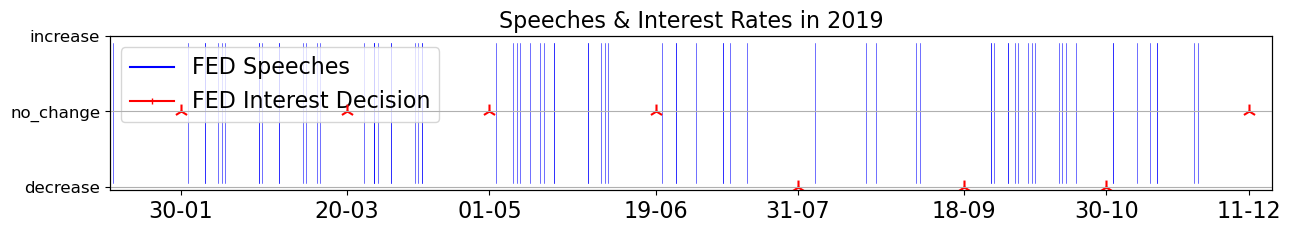

In [269]:
#plot interest decisions dates and speeches dates ogether for 2019.
#Every red star represents an interest decision date, The blue lines represent FED speeches dates.
speech_interest_visualize(2019, data, fed_interest)

In [35]:
#tagged_df
tagged_df[tagged_df['Decision_Date'].dt.year==2019].head(5)

,Decision,Texts,Decision_Date,Texts_Count
5,no_change,Good morning. I am honored and delighted to participate in this second annual conference on glo...,2019-12-11,5
6,decrease,"Good morning, and welcome to the Federal Reserve Board's research conference ""Nontraditional Da...",2019-10-30,11
7,decrease,Thank you for the kind introduction and for this opportunity to recognize the contributions of ...,2019-09-18,4
8,decrease,I am delighted to be in Helsinki at this important conference on monetary policy and the future...,2019-07-31,5
9,no_change,I am pleased to attend this Fed Listens event providing the New York perspective for the Federa...,2019-06-19,7


### 3. <u>Load GPT generated interest anchors.</u>

##### 3.1.Explicit Interest Change Anchors

In [5]:
# 40 topics in the form of sentences related to interest increase or decrease were generated using chatgpt.
# these sentences are explicit as they include the word interest.

anchor_sentences= pd.read_csv('datasets/interest_related_sentences.csv')

#all anchors in one list
explicit_anchors= pd.concat([anchor_sentences.loc[:19,'Decrease'], anchor_sentences.loc[:19,'Increase']], axis=0).to_list()

pd.set_option('max_colwidth', 200)
pd.DataFrame(explicit_anchors, columns=['Explicit_Anchors']).head(5)




,Explicit_Anchors
0,"Given the current economic uncertainties, it might be prudent to consider a gradual reduction in interest rates to stimulate economic growth."
1,A potential rate cut could help alleviate the financial burden on businesses struggling in these challenging times.
2,"Lowering interest rates may encourage consumers to increase their spending, thereby boosting overall demand."
3,We should evaluate the impact of a rate reduction on the housing market and assess its potential to increase homeownership.
4,An interest rate decrease can be a vital tool in our efforts to combat deflationary pressures.


In [44]:
len(explicit_anchors)

40

##### 3.2.Implicit Interest Change Anchors

In [6]:
#Similarily 40 implicit sentences that might be related to increase/decrease of interest were generated.
#These sentences dont include the word interest directly.

anchor_sentences= pd.read_csv('datasets/interest_related_sentences.csv')

implicit_anchors= pd.concat([anchor_sentences.loc[20:,'Decrease'], anchor_sentences.loc[20:,'Increase']], axis=0).to_list()
len(implicit_anchors)

pd.DataFrame(implicit_anchors, columns=['Implicit_Anchors']).head(5)

,Implicit_Anchors
0,Economic growth is showing signs of accelerati...
1,Inflation rates have been gradually trending u...
2,"Unemployment figures are steadily declining, r..."
3,"Consumer spending has been on the rise, contri..."
4,Investments in various sectors are experiencin...


### 4. <u>Modeling</u>

##### 4.1 Explicit Anchor sentences

##### 4.1.1. Transform Explicit sentences to framing evidence features

In [ ]:
# 1.speeches were chunked to sentences.
# 2.these sentences were transformed to embeddings.
# 3.explicit anchors were transformed to embeddings.
# 4.for each sentence in every speech, cosine similarity was calculated to each anchor sentence.
# 5.for every text, the highest cosine similarity of a sentence to each anchor sentence was saved.
# 6.each anchor sentence will serve as a feature with its matching saved values. "framing evidence features".

# model_name= "distilbert-base-nli-stsb-mean-tokens"

# ev_extractor= EvidenceExtractor(sentence_breaker, explicit_anchors, model_name)
# ev_extractor.fit(tagged_df['Texts'])
# ev_features= ev_extractor.transform(tagged_df['Texts'])

In [212]:
# total of 45,249 sentences embbedings from speeches.

# np.vstack(ev_extractor.sentence_embeddings).shape

(45249, 768)

In [227]:
#save evidence features to both csv and feather files

# ev_features.to_csv("ev_features.csv")
# ev_features.columns = ev_features.columns.astype(str)
# ev_features.to_feather("ev_features.feather") #needed for feather file
# ev_features

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.495855,0.423037,0.405876,0.420776,0.484469,0.448895,0.361430,0.386092,0.464401,0.493720,...,0.382818,0.417066,0.417648,0.327729,0.494161,0.339097,0.410806,0.483162,0.529184,0.414591
1,0.365257,0.406877,0.310984,0.383925,0.347543,0.344843,0.425914,0.449754,0.494543,0.500211,...,0.450927,0.458227,0.324872,0.441782,0.350633,0.358776,0.405320,0.402752,0.314320,0.557184
2,0.653487,0.602205,0.452112,0.462759,0.595758,0.513085,0.457459,0.591867,0.605413,0.540714,...,0.437428,0.457811,0.436517,0.527063,0.508097,0.374261,0.505709,0.596906,0.478969,0.541800
3,0.653487,0.665018,0.567926,0.473279,0.595758,0.582565,0.633385,0.591867,0.605413,0.605615,...,0.674643,0.602427,0.597266,0.542274,0.508097,0.586285,0.605413,0.613429,0.509471,0.638643
4,0.605225,0.502954,0.399275,0.413088,0.535726,0.520716,0.486959,0.571656,0.608835,0.503588,...,0.526342,0.496055,0.468802,0.432728,0.452005,0.395696,0.477224,0.531003,0.399465,0.556057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.698515,0.695837,0.675475,0.600037,0.699547,0.660034,0.665111,0.716237,0.651402,0.648701,...,0.703071,0.699527,0.774010,0.624916,0.656946,0.702853,0.701585,0.671295,0.650808,0.729983
139,0.693890,0.681860,0.787359,0.568466,0.691681,0.659406,0.647482,0.728757,0.572178,0.703180,...,0.701255,0.764101,0.753725,0.597005,0.650827,0.760367,0.658797,0.686994,0.620158,0.682338
140,0.721379,0.749030,0.684106,0.699531,0.725810,0.663669,0.631045,0.657480,0.650783,0.662451,...,0.647772,0.712863,0.677844,0.599047,0.611126,0.750795,0.677124,0.658298,0.598349,0.691991
141,0.702752,0.692735,0.717893,0.566724,0.776096,0.653363,0.643266,0.648649,0.563712,0.662451,...,0.663663,0.781185,0.677844,0.599047,0.642244,0.750795,0.756000,0.658298,0.630923,0.713526


In [49]:
#X features

X= pd.read_csv('backups/ev_features.csv').drop(columns='Unnamed: 0')
X

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.495855,0.423037,0.405876,0.420776,0.484469,0.448895,0.361430,0.386092,0.464401,0.493720,...,0.382818,0.417066,0.417648,0.327729,0.494161,0.339097,0.410806,0.483162,0.529184,0.414591
1,0.365257,0.406877,0.310984,0.383925,0.347543,0.344843,0.425914,0.449754,0.494543,0.500211,...,0.450927,0.458227,0.324872,0.441782,0.350633,0.358776,0.405320,0.402752,0.314320,0.557184
2,0.653487,0.602205,0.452112,0.462759,0.595758,0.513085,0.457459,0.591867,0.605413,0.540714,...,0.437428,0.457811,0.436517,0.527063,0.508097,0.374261,0.505709,0.596906,0.478969,0.541800
3,0.653487,0.665018,0.567926,0.473279,0.595758,0.582565,0.633385,0.591867,0.605413,0.605615,...,0.674643,0.602427,0.597266,0.542274,0.508097,0.586285,0.605413,0.613429,0.509471,0.638643
4,0.605225,0.502954,0.399275,0.413088,0.535726,0.520716,0.486959,0.571656,0.608835,0.503588,...,0.526342,0.496055,0.468802,0.432728,0.452005,0.395696,0.477224,0.531003,0.399465,0.556057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.698515,0.695837,0.675475,0.600037,0.699547,0.660034,0.665111,0.716237,0.651402,0.648701,...,0.703071,0.699527,0.774010,0.624916,0.656946,0.702853,0.701585,0.671295,0.650808,0.729983
139,0.693890,0.681860,0.787359,0.568466,0.691681,0.659406,0.647482,0.728757,0.572178,0.703180,...,0.701255,0.764101,0.753725,0.597005,0.650827,0.760367,0.658797,0.686994,0.620158,0.682338
140,0.721379,0.749030,0.684106,0.699531,0.725810,0.663669,0.631045,0.657480,0.650783,0.662451,...,0.647772,0.712863,0.677844,0.599047,0.611126,0.750795,0.677124,0.658298,0.598349,0.691991
141,0.702752,0.692735,0.717893,0.566724,0.776096,0.653363,0.643266,0.648649,0.563712,0.662451,...,0.663663,0.781185,0.677844,0.599047,0.642244,0.750795,0.756000,0.658298,0.630923,0.713526


##### 4.1.2. Explicit Anchors Model

In [50]:
#model- with explicit anchor sentences.

params = {
    'objective': 'multiclass',
    'class_weight': 'balanced',
    #'min_split_gain': 10,
    #'num_leaves': 40,
    'random_state': 42,
    'verbose': -1,   
}

model= lgb.LGBMClassifier(**params)

#data
y = tagged_df['Decision']
X = X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

#results
show_metrics(y_test, y_pred)



+-----------+-----------+--------+----------+---------+
|   Class   | Precision | Recall | F1-Score | Support |
+-----------+-----------+--------+----------+---------+
|           |           |        |          |         |
| decrease  |   0.75    |  0.60  |   0.67   |    5    |
| increase  |   0.67    |  0.33  |   0.44   |    6    |
| no_change |   0.77    |  0.94  |   0.85   |   18    |
|           |           |        |          |         |
| accuracy  |   0.76    |   29   |          |         |
|   macro   |    avg    |  0.73  |   0.63   |  0.65   |
| weighted  |    avg    |  0.75  |   0.76   |  0.73   |
|           |           |        |          |         |
+-----------+-----------+--------+----------+---------+


##### 4.1.3. Importance Of explicit Sentences

In [52]:
#importance of explicit anchor sentences

feature_names = X_train.columns
feature_importances = model.feature_importances_
feature_importance_pairs = list(zip(feature_names, feature_importances))
feature_importance_df = pd.DataFrame(feature_importance_pairs, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
feature_importance_df['Explicit_Anchor']=pd.DataFrame(explicit_anchors)
feature_importance_df

,Feature,Importance,Explicit_Anchor
0,0,62,"Given the current economic uncertainties, it might be prudent to consider a gradual reduction in interest rates to stimulate economic growth."
19,19,59,A targeted approach to lowering interest rates for specific industries may yield positive economic outcomes.
28,28,55,Rising interest rates can act as a buffer against excessive risk-taking and credit expansion.
14,14,52,Forward guidance on future rate cuts should be communicated clearly to guide market expectations and investor decisions.
9,9,49,Effectively communicating our rationale for a rate reduction is essential to manage market expectations.
21,21,48,An increase in interest rates can help cool an overheated housing market and mitigate speculative excesses.
12,12,41,"Quantitative easing, combined with lower interest rates, can provide additional support to the economy."
5,5,36,It is crucial to monitor global economic trends to assess the impact of lower interest rates on international trade.
33,33,35,"Quantitative tightening, combined with rate hikes, can be an effective tool to prevent asset bubbles."
15,15,35,"As we embark on a path of decreasing interest rates, we must consider the challenges, such as the risk of asset bubbles."


##### 4.2. Implicit Anchor sentences

##### 4.2.1. Transform Implicit sentences to framing evidence features

In [7]:
#some sentences example
pd.DataFrame(implicit_anchors).head(5)

,0
0,"Economic growth is showing signs of acceleration, fostering optimism in financial markets."
1,"Inflation rates have been gradually trending upward, prompting discussions about potential monetary policy adjustments."
2,"Unemployment figures are steadily declining, reflecting positive developments in the labor market."
3,"Consumer spending has been on the rise, contributing to a more buoyant economic environment."
4,"Investments in various sectors are experiencing a noticeable uptick, indicating increased business confidence."


In [26]:
#should try this with sentence_breaker3- which is better.

#transform speeches and anchor sentences to framing evidence features- with implicit anchor sentences.

# model_name= "distilbert-base-nli-stsb-mean-tokens"

# ev_extractor= EvidenceExtractor(sentence_breaker, implicit_anchors, model_name)
# ev_extractor.fit(tagged_df['Texts'])
# ev_features_implicit= ev_extractor.transform(tagged_df['Texts'])

In [27]:
#45,249 sentences embedings.

# np.vstack(ev_extractor.sentence_embeddings).shape

(45249, 768)

In [28]:
#save evidence features to both csv and feather.show the features.

# ev_features_implicit.to_csv("ev_features_implicit.csv")
# ev_features_implicit.columns = ev_features_implicit.columns.astype(str)
# ev_features_implicit.to_feather("ev_features_implicit.feather") #needed for feather file
# ev_features_implicit

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.383119,0.532138,0.538253,0.394633,0.335241,0.263939,0.522896,0.558334,0.328165,0.391194,...,0.377436,0.336108,0.560941,0.323381,0.424182,0.481542,0.420033,0.459683,0.332849,0.480345
1,0.389178,0.355655,0.299257,0.368344,0.413855,0.325608,0.160384,0.453489,0.351281,0.503470,...,0.531827,0.419155,0.270013,0.425873,0.485205,0.435194,0.426835,0.536679,0.492700,0.547611
2,0.512328,0.536163,0.514843,0.394283,0.358935,0.357915,0.586006,0.503982,0.438481,0.493937,...,0.431048,0.480648,0.522796,0.487715,0.569075,0.532960,0.472014,0.527715,0.465870,0.600973
3,0.575758,0.536163,0.522449,0.588814,0.605612,0.414395,0.586006,0.572187,0.588451,0.646882,...,0.664191,0.489874,0.522796,0.524405,0.610890,0.532960,0.583077,0.656034,0.617509,0.600973
4,0.412761,0.555036,0.586152,0.375373,0.413630,0.321565,0.559644,0.562184,0.550018,0.536816,...,0.571279,0.547988,0.589321,0.478616,0.524253,0.530967,0.537007,0.468228,0.491242,0.580091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.681462,0.631593,0.699584,0.606473,0.694579,0.581078,0.682721,0.744357,0.659590,0.720166,...,0.718990,0.645071,0.751414,0.612369,0.718712,0.694352,0.700029,0.727851,0.730403,0.702927
139,0.700940,0.628407,0.667621,0.645832,0.686007,0.573449,0.685494,0.712419,0.717414,0.704894,...,0.698736,0.670252,0.659718,0.717521,0.725022,0.706612,0.729757,0.676067,0.683631,0.697657
140,0.742087,0.676593,0.705052,0.772696,0.755159,0.602106,0.753730,0.729142,0.633370,0.717430,...,0.727157,0.644362,0.706114,0.668304,0.746108,0.680350,0.752082,0.661136,0.707672,0.700865
141,0.742087,0.668411,0.682382,0.772696,0.755159,0.675551,0.742586,0.729142,0.642453,0.717430,...,0.678417,0.644362,0.675011,0.663814,0.746108,0.668490,0.752082,0.661136,0.735323,0.674430


In [7]:
# implicit features
X2= pd.read_csv('backups/ev_features_implicit.csv').drop(columns='Unnamed: 0')

In [8]:
X2.head(1)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.383119,0.532138,0.538253,0.394633,0.335241,0.263939,0.522896,0.558334,0.328165,0.391194,...,0.377436,0.336108,0.560941,0.323381,0.424182,0.481542,0.420033,0.459683,0.332849,0.480345


##### 4.2.2. Implicit Anchors Model

In [9]:
#model with implicit sentence anchors.
params = {
    'objective': 'multiclass',
    'class_weight': 'balanced',
    #'min_split_gain': 10,
    #'num_leaves': 40,
    'random_state': 42,
    'verbose': -1,   
}

model= lgb.LGBMClassifier(**params)

#data
y = tagged_df['Decision']
X = X2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

#results
show_metrics(y_test, y_pred)



+-----------+-----------+--------+----------+---------+
|   Class   | Precision | Recall | F1-Score | Support |
+-----------+-----------+--------+----------+---------+
|           |           |        |          |         |
| decrease  |   0.75    |  0.60  |   0.67   |    5    |
| increase  |   0.38    |  0.50  |   0.43   |    6    |
| no_change |   0.82    |  0.78  |   0.80   |   18    |
|           |           |        |          |         |
| accuracy  |   0.69    |   29   |          |         |
|   macro   |    avg    |  0.65  |   0.63   |  0.63   |
| weighted  |    avg    |  0.72  |   0.69   |  0.70   |
|           |           |        |          |         |
+-----------+-----------+--------+----------+---------+


##### 4.2.3. Importance Of implicit Sentences

In [66]:
#importance of explicit anchor sentences

feature_names = X_train.columns
feature_importances = model.feature_importances_
feature_importance_pairs = list(zip(feature_names, feature_importances))
feature_importance_df = pd.DataFrame(feature_importance_pairs, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
feature_importance_df['Implicit_Anchor']=pd.DataFrame(implicit_anchors)
feature_importance_df

,Feature,Importance,Implicit_Anchor
21,21,97,"Inflation rates have shown an upward trajectory, raising concerns about the possibility of policy tightening."
17,17,84,"Employment opportunities are diversifying, leading to a more inclusive and dynamic job market."
34,34,67,"Market liquidity remains ample, but central banks are monitoring potential risks associated with prolonged accommodative policies."
33,33,66,"Credit conditions are tightening, reflecting a more cautious approach by central banks to lending and borrowing."
35,35,56,"Trade balances are under scrutiny, with central banks considering measures to address imbalances and inflationary pressures."
11,11,47,Forward guidance from central banks is shaping market expectations and influencing investor behavior.
25,25,46,"The housing market is experiencing a surge in prices and activity, leading to discussions about the need for policy adjustments."
12,12,43,Political considerations are contributing to a cautious but optimistic approach to monetary policy decisions.
6,6,38,"Currency values have exhibited a moderate decline, potentially impacting trade dynamics."
19,19,36,Policy adjustments are aligned with broader efforts to sustain a balanced and sustainable economic trajectory.


In [ ]:
#f_names= np.array(model.feature_name_)

### 5. <u>Real-Time Prediction of Interest Decisions as Speech Progresses</u>

##### 5.1. by sentence progress

In [370]:
#pick a speech
#this speech has 4,307 words
study_speech=tagged_df['Texts'][0]
len(study_speech.split())

4307

In [207]:
#it has 213 sentences.
len(sentence_breaker3(study_speech))

213

In [208]:
#create a list of cumulative sentences from the speech.
cum_sen=cumulate_sentences(data=tagged_df['Texts'], text_num=0)

In [209]:
cum_sen.head(3)

0                                                                                              The coronavirus has left a devastating human and economic toll in its wake as it has spread around the globe.
1    The coronavirus has left a devastating human and economic toll in its wake as it has spread around the globe. This is a worldwide public health crisis, and health-care workers have been the first ...
2    The coronavirus has left a devastating human and economic toll in its wake as it has spread around the globe. This is a worldwide public health crisis, and health-care workers have been the first ...
dtype: object

In [211]:
#create framing evidence features

# model_name= "distilbert-base-nli-stsb-mean-tokens"

# ev_extractor= EvidenceExtractor(sentence_breaker3, implicit_anchors, model_name)
# ev_extractor.fit(cum_sen)
# ev_features_study_speech= ev_extractor.transform(cum_sen)

#save evidence features to both csv and feather.show the features.

#ev_features_study_speech.to_csv("ev_features_study_speech.csv")
#ev_features_study_speech

Processing Text: 100%|██████████| 213/213 [24:16<00:00,  6.84s/speech]


In [214]:
#22,790 sentences embedings.
# np.vstack(ev_extractor.sentence_embeddings).shape

(22790, 768)

In [219]:
ev_single_speech= pd.read_csv('ev_features_study_speech.csv').drop(columns='Unnamed: 0')

In [222]:
#predict onspeeches cumulative sentences
y_pred = model.predict_proba(ev_single_speech)

In [224]:
model.classes_

array(['decrease', 'increase', 'no_change'], dtype=object)

In [242]:
prob= pd.DataFrame(y_pred) #all classes predict proba
prob_increase= prob.loc[:,1] #increase column probabilities

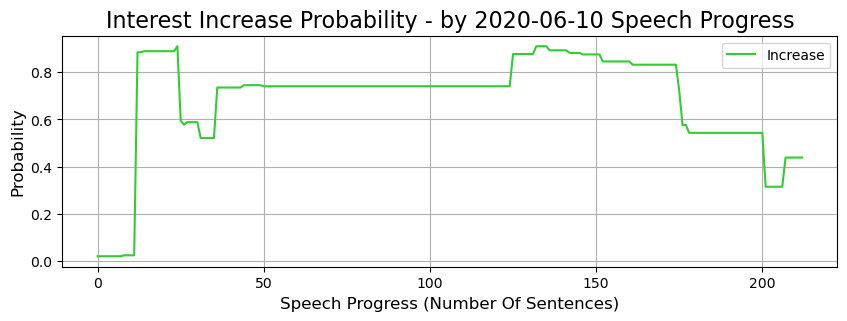

In [366]:
plot_one_class(prob_increase, tagged_df['Decision_Date'], text_num=0)

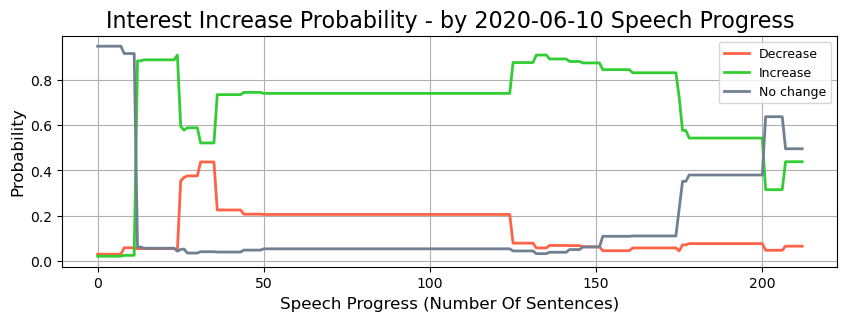

In [368]:
plot_some_classes(prob, tagged_df['Decision_Date'], text_num=0)

##### 5.2 Identification of Critical Interest Prediction Highlights

In [80]:
#return the 5 most important anchors (features) in the decision of a certain speech.
top_5_anchors= specific_anchors_explainer(X_explain=X2.iloc[0,:], 
                                          model=model, 
                                          anchors=implicit_anchors, 
                                          explainer=shap.TreeExplainer, 
                                          top_num=5
                                          )
top_5_anchors

['Investments in various sectors are experiencing a noticeable uptick, indicating increased business confidence.',
 'Credit conditions are gradually improving, facilitating easier access to financing for various entities.',
 'Forward guidance from central banks is signaling a potential shift towards a more hawkish stance.',
 'Global economic conditions are robust, prompting central banks to reassess their accommodative policy stance.',
 'Increased confidence in the financial sector is prompting central banks to evaluate the impact of rising interest rates on stability.']

In [76]:
##Return the speeches "highlights": 
#the most important sentences in the text that led to that specific prediction.

highlights_extractor= HighlightsExtractor(sentence_breaker3, top_5_anchors, "distilbert-base-nli-stsb-mean-tokens")
highlights_extractor.fit(tagged_df['Texts'][0])
highlights_implicit= highlights_extractor.transform(tagged_df['Texts'][0])


In [77]:
#show the highlight next to the matching similar anchors

pd.set_option('max_colwidth', 400)
implicit_decision_highlights=pd.DataFrame({'Implicit_Highlights':highlights_implicit[0], 
                                           'Implicit_Anchor':top_5_anchors})
implicit_decision_highlights



,Implicit_Highlights,Implicit_Anchor
178,"Last year, we heard from small businesses that were expanding their workforces and investing in their communities.","Investments in various sectors are experiencing a noticeable uptick, indicating increased business confidence."
25,"Second, liquidity and funding measures, including discount window measures, expanded swap lines with foreign central banks, and several facilities with Treasury backing to support smooth functioning in money markets.","Credit conditions are gradually improving, facilitating easier access to financing for various entities."
25,"Second, liquidity and funding measures, including discount window measures, expanded swap lines with foreign central banks, and several facilities with Treasury backing to support smooth functioning in money markets.",Forward guidance from central banks is signaling a potential shift towards a more hawkish stance.
161,"But there is one thing that I am certain about: The Federal Reserve will continue to act forcefully, proactively, and aggressively as we deploy our toolkitâincluding our balance sheet, forward guidance, and lending facilitiesâto provide critical support to the economy during this challenging time and to do all we can to make sure that the recovery from this downturn, once it commences, is ...","Global economic conditions are robust, prompting central banks to reassess their accommodative policy stance."
25,"Second, liquidity and funding measures, including discount window measures, expanded swap lines with foreign central banks, and several facilities with Treasury backing to support smooth functioning in money markets.",Increased confidence in the financial sector is prompting central banks to evaluate the impact of rising interest rates on stability.
